In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
from sklearn.datasets import load_breast_cancer, load_digits, load_iris, load_wine
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from src.tabpfn import TabPFNClassifier

import torch

import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

## Experiment on load breast_cancer dataset

In [2]:
# Load data
X, y = load_breast_cancer(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

# Initialize a classifier
clf = TabPFNClassifier()  # Uses TabPFN 2.5 weights, finetuned on real data.
clf.fit(X_train, y_train)

# Predict probabilities
prediction_probabilities = clf.predict_proba(X_test)
# Predict labels
predictions = clf.predict(X_test)
print("Accuracy", accuracy_score(y_test, predictions))

Inverse transforming predicted labels to original encoding.
Accuracy 0.9824561403508771


In [3]:
# test fit with differentiable inputs and outputs by converting the data to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)
clf = TabPFNClassifier()
clf.fit(X_train_tensor, y_train_tensor)

prediction_probabilities_tensor = clf.predict_proba(X_test_tensor)
predictions_tensor = clf.predict(X_test_tensor)
print("Accuracy with tensors", accuracy_score(y_test_tensor, predictions_tensor))

Inverse transforming predicted labels to original encoding.
Accuracy with tensors 0.9824561403508771


In [4]:
# test fit with differentiable inputs and outputs by converting the data to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)
clf = TabPFNClassifier(differentiable_input=True)
clf.fit_with_differentiable_input(X_train_tensor, y_train_tensor)

prediction_probabilities_tensor = clf.predict_proba(X_test_tensor)
logits_tensor = clf.predict_logits(X_test_tensor)
y_pred_tensor = clf.predict(X_test_tensor)

#print("Accuracy with differentiable input", accuracy_score(y_test_tensor, predictions_tensor))

In [5]:
# test fit with differentiable inputs and outputs by converting the data to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)
clf = TabPFNClassifier(differentiable_input=True)
clf.fit_with_differentiable_input(X_train_tensor, y_train_tensor)
X_test_tensor.requires_grad = True
prediction_probabilities_tensor = clf.predict_proba(X_test_tensor)
logits_tensor = clf.predict_logits(X_test_tensor)
loss = torch.nn.CrossEntropyLoss()(logits_tensor, y_test_tensor.to('cuda'))
# compute gradient wrt to test input
X_test_grad = torch.autograd.grad(loss  , X_test_tensor)[0]

#print("Accuracy with differentiable input", accuracy_score(y_test_tensor, predictions_tensor))

In [6]:
# checking if we can "attack" the model by computing the gradient of the loss wrt the input and then doing a step in that direction to increase the loss
# first w.r.t to the test input
n_iterations = 15
n_rep = 1
accuracies = []
losses = []
epsilon = 1.
for i in range(n_rep):
    print(f"rep: {i}")
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32, requires_grad=True)
    y_test_tensor = torch.tensor(y_test, dtype=torch.long)
    clf = TabPFNClassifier(differentiable_input=True)
    clf.fit_with_differentiable_input(X_train_tensor, y_train_tensor)
    accuracies.append(accuracy_score(y_test_tensor.cpu(), clf.predict(X_test_tensor).cpu()))
    for iteration in tqdm(range(n_iterations)):
        prediction_probabilities_tensor = clf.predict_proba(X_test_tensor)
        logits_tensor = clf.predict_logits(X_test_tensor)
        loss = torch.nn.CrossEntropyLoss()(logits_tensor, y_test_tensor.to('cuda'))
        losses.append(loss.item())
        # compute gradient wrt to test input
        X_test_grad = torch.autograd.grad(loss  , X_test_tensor)[0]
        # do a step in the direction of the gradient to increase the loss
        with torch.no_grad():
            normed_grad = X_test_grad / (torch.norm(X_test_grad) + 1e-8)
            X_test_tensor += epsilon * normed_grad
        print(f"X_test_required_grad: {X_test_tensor.requires_grad}")
        y_logits = clf.predict_logits(X_test_tensor)
        predictions_tensor = torch.argmax(y_logits, dim=1).cpu().detach().numpy()
        accuracies.append(accuracy_score(y_test_tensor.cpu(), predictions_tensor))

rep: 0


  0%|          | 0/15 [00:00<?, ?it/s]

X_test_required_grad: True


  7%|▋         | 1/15 [00:01<00:18,  1.31s/it]

X_test_required_grad: True


 13%|█▎        | 2/15 [00:02<00:17,  1.36s/it]

X_test_required_grad: True


 20%|██        | 3/15 [00:04<00:18,  1.56s/it]

X_test_required_grad: True


 27%|██▋       | 4/15 [00:06<00:18,  1.65s/it]

X_test_required_grad: True


 33%|███▎      | 5/15 [00:08<00:17,  1.72s/it]

X_test_required_grad: True


 40%|████      | 6/15 [00:09<00:15,  1.72s/it]

X_test_required_grad: True


 47%|████▋     | 7/15 [00:11<00:12,  1.62s/it]

X_test_required_grad: True


 53%|█████▎    | 8/15 [00:12<00:11,  1.62s/it]

X_test_required_grad: True


 60%|██████    | 9/15 [00:14<00:09,  1.56s/it]

X_test_required_grad: True


 67%|██████▋   | 10/15 [00:15<00:07,  1.52s/it]

X_test_required_grad: True


 73%|███████▎  | 11/15 [00:17<00:06,  1.50s/it]

X_test_required_grad: True


 80%|████████  | 12/15 [00:18<00:04,  1.49s/it]

X_test_required_grad: True


 87%|████████▋ | 13/15 [00:20<00:02,  1.49s/it]

X_test_required_grad: True


 93%|█████████▎| 14/15 [00:21<00:01,  1.48s/it]

X_test_required_grad: True


100%|██████████| 15/15 [00:23<00:00,  1.54s/it]


Text(0.5, 1.0, 'Accuracy | attack on test data')

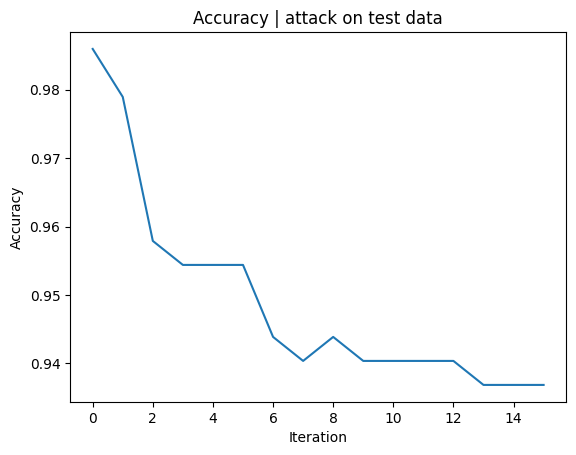

In [7]:
iterations = list(range(n_iterations * n_rep + 1))
plt.plot(iterations, accuracies)
plt.xlabel("Iteration")
plt.ylabel("Accuracy")

plt.title("Accuracy | attack on test data")    

In [12]:
# test fit with differentiable inputs and outputs by converting the data to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)
X_train_tensor.requires_grad = True
clf = TabPFNClassifier(differentiable_input=True)
clf.fit_with_differentiable_input(X_train_tensor, y_train_tensor)

prediction_probabilities_tensor = clf.predict_proba(X_test_tensor)
logits_tensor = clf.predict_logits(X_test_tensor)
# compute gradient wrt to test input
X_train_grad = torch.autograd.grad(logits_tensor.sum(), X_train_tensor)[0]
#print("Accuracy with differentiable input", accuracy_score(y_test_tensor, predictions_tensor))

In [13]:
# testing attack on X_train by computing the gradient of the loss wrt the input and then doing a step in that direction to increase the loss
n_iterations = 15
n_rep = 1
accuracies = []
losses = []
epsilon = 1.
for i in range(n_rep):
    print(f"rep: {i}")
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32, requires_grad=True)
    y_train_tensor = torch.tensor(y_train, dtype=torch.long)
    clf = TabPFNClassifier(differentiable_input=True)
    clf.fit_with_differentiable_input(X_train_tensor, y_train_tensor)
    y_logits = clf.predict_logits(X_test_tensor)
    accuracies.append(accuracy_score(y_test_tensor.cpu(), torch.argmax(y_logits, dim=1).cpu().detach().numpy()))
    
    for iteration in tqdm(range(n_iterations)):
        prediction_probabilities_tensor = clf.predict_proba(X_test_tensor)
        logits_tensor = clf.predict_logits(X_test_tensor)
        loss = torch.nn.CrossEntropyLoss()(logits_tensor, y_test_tensor.to('cuda'))
        losses.append(loss.item())
        # compute gradient wrt to test input
        X_train_grad = torch.autograd.grad(loss  , X_train_tensor)[0]
        # do a step in the direction of the gradient to increase the loss
        with torch.no_grad():
            normed_grad = X_train_grad / (torch.norm(X_train_grad) + 1e-8)
            X_train_tensor += epsilon * normed_grad
        clf.fit_with_differentiable_input(X_train_tensor, y_train_tensor)
        y_logits = clf.predict_logits(X_test_tensor)
        predictions_tensor = torch.argmax(y_logits, dim=1).cpu().detach().numpy()
        accuracies.append(accuracy_score(y_test_tensor.cpu(), predictions_tensor))

rep: 0


100%|██████████| 15/15 [00:24<00:00,  1.61s/it]


Text(0.5, 1.0, 'Accuracy | attack on training data')

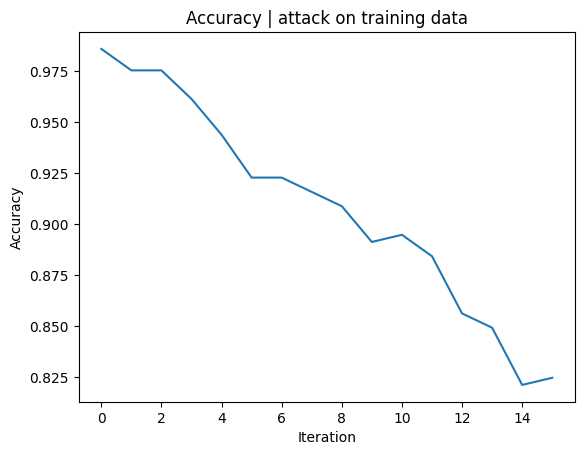

In [14]:
iterations = list(range(n_iterations * n_rep + 1))
plt.plot(iterations, accuracies)
plt.xlabel("Iteration")
plt.ylabel("Accuracy")

plt.title("Accuracy | attack on training data")    